Преобразуйте изображение в тензоры цветовых каналов R, G, B (можно
использовать инструменты библиотеки matplotlib.image, cv2 или другой на
выбор, см. блокнот от 22.03.2025 с практики)

In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
from tensorflow.python.ops.numpy_ops.np_math_ops import nansum

r = np.random.RandomState(69)


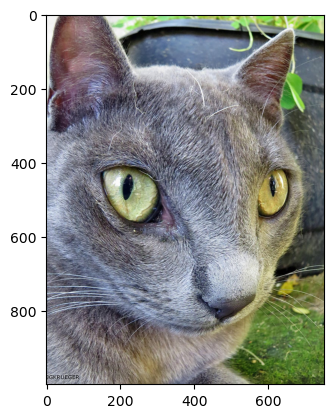

In [166]:
img = image.imread(r'C:\Users\user\PycharmProjects\NAM\lab2\kot-eti-udivitelnye-kotiki.jpg')

plt.imshow(img)
plt.show()

R, G, B = img[:, :, 0] / 0xff, img[:, :, 1] / 0xff, img[:, :, 2] / 0xff

R_U, R_S, R_VT = np.linalg.svd(R)
G_U, G_S, G_VT = np.linalg.svd(G)
B_U, B_S, B_VT = np.linalg.svd(B)


In [ ]:
def read_from_shrinked(U, S, VT):
    return (U @ S @ VT)


def restore_image(R, G, B):
    R_restored = read_from_shrinked(R[0], R[1], R[2])
    G_restored = read_from_shrinked(G[0], G[1], G[2])
    B_restored = read_from_shrinked(B[0], B[1], B[2])
    restored_float = np.dstack((R_restored, G_restored, B_restored))
    img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

    plt.imshow(img_restored)
    plt.show()


Выполните сингулярное разложение тензоров R, G, B при помощи
степенного метода. Внимание: размеры изображения width, height задают
размер матрицы n, m (учтите это обстоятельство в процедуре при генерации
вектора-начального приближения); число итераций N для степенного метода
N = {10; 50; 100}. Если при расчете появятся отрицательные оценки сингулярных чисел – отметьте это в отчете
и объясните причину (мы же понимаем, что так быть не должно – в чем
ошибка?).

In [189]:
def singular_decomposition(A, N):
    n = A.shape[0]
    m = A.shape[1]
    r = np.linalg.matrix_rank(A)

    def pm(M, limit):
        x = np.ones(m)
        x = x / np.linalg.norm(x, 2)
        for _ in range(limit):
            x = M @ x
            x = x / np.linalg.norm(x, 2)
        ev = (M @ x @ x) / (x @ x)
        return ev, x

    M = A.T @ A

    UT = []
    VT = []
    S = []

    for _ in range(r):
        res = pm(M, N)
        lam, v = res[0], res[1]
        s = np.sqrt(lam) if lam > 0 else 0
        if s == 0:
            continue
        u = A @ v / s
        UT.append(u)
        S.append(s)
        VT.append(v)
        M = M - lam * np.outer(v, v)

    VT = np.array(VT)
    U = np.array(UT).T
    S = np.diag(S) if S else np.zeros((A.shape[0], A.shape[1]))

    return U, S, VT


R_SVD = [singular_decomposition(R, N) for N in [10, 50, 100]]
G_SVD = [singular_decomposition(G, N) for N in [10, 50, 100]]
B_SVD = [singular_decomposition(B, N) for N in [10, 50, 100]]


In [190]:
N = [10, 50, 100]
for N_i in range(3):
    print(f'N = {N[N_i]}')
    print(f'R: {np.linalg.norm(R - R_SVD[N_i][0] @ R_SVD[N_i][1] @ R_SVD[N_i][2])}')
    print(f'G: {np.linalg.norm(G - G_SVD[N_i][0] @ G_SVD[N_i][1] @ G_SVD[N_i][2])}')
    print(f'B: {np.linalg.norm(B - B_SVD[N_i][0] @ B_SVD[N_i][1] @ B_SVD[N_i][2])}')


N = 10
R: 27.0150605689171
G: 72.65311226968387
B: 26.988259758109958
N = 50
R: 5.086063807019247
G: 3.885548191290563
B: 4.51836133986169
N = 100
R: 1.1435608055100686
G: 2.148860584389862
B: 1.467668097577032


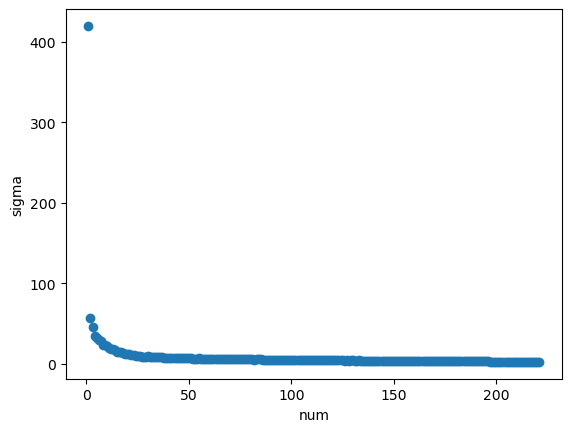

27.0150605689171


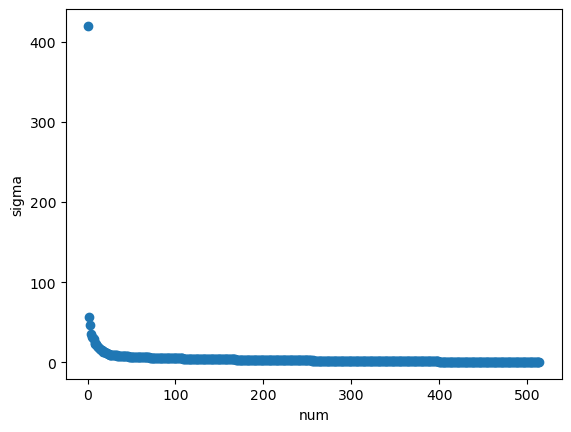

5.086063807019247


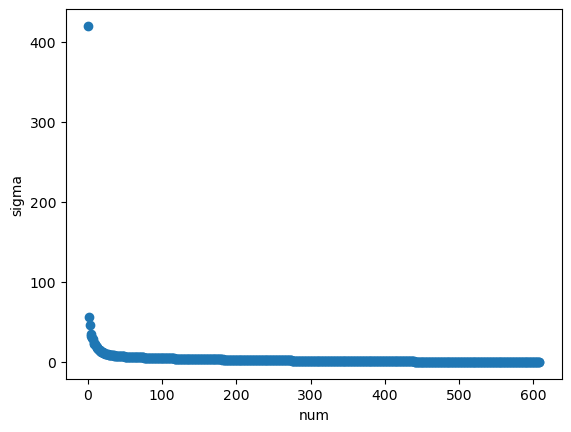

1.1435608055100686


In [212]:
def plot_singular_values(S, i):
    plt.scatter(np.arange(1, S.shape[0] + 1, 1), np.diag(S))
    plt.xlabel('num')
    plt.ylabel('sigma')
    plt.show()
    print(f'{np.linalg.norm(R - R_SVD[i][0] @ R_SVD[i][1] @ R_SVD[i][2])}')


for i in range(3):
    plot_singular_values(R_SVD[i][1], i)

In [217]:
def singular_decomposition_truncated(A, N, k):
    n = A.shape[0]
    m = A.shape[1]
    r = np.linalg.matrix_rank(A)

    def pm(M, limit):
        x = np.ones(m)
        x = x / np.linalg.norm(x, 2)
        for _ in range(limit):
            x = M @ x
            x = x / np.linalg.norm(x, 2)
        ev = (M @ x @ x) / (x @ x)
        return ev, x

    M = A.T @ A

    UT = []
    VT = []
    S = []

    for _ in range(k):
        res = pm(M, N)
        lam, v = res[0], res[1]
        s = np.sqrt(lam) if lam > 0 else 0
        if s == 0:
            continue
        u = A @ v / s
        UT.append(u)
        S.append(s)
        VT.append(v)
        M = M - lam * np.outer(v, v)

    VT = np.array(VT)
    U = np.array(UT).T
    S = np.diag(S) if S else np.zeros((A.shape[0], A.shape[1]))

    return U, S, VT


R_T_SVD = [singular_decomposition_truncated(R, 100, k) for k in range(1, 101, 20)]
G_T_SVD = [singular_decomposition_truncated(G, 100, k) for k in range(1, 101, 20)]
B_T_SVD = [singular_decomposition_truncated(B, 100, k) for k in range(1, 101, 20)]


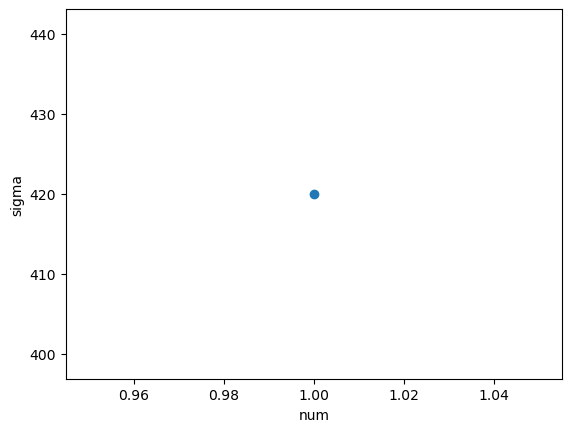

139.18069537056093


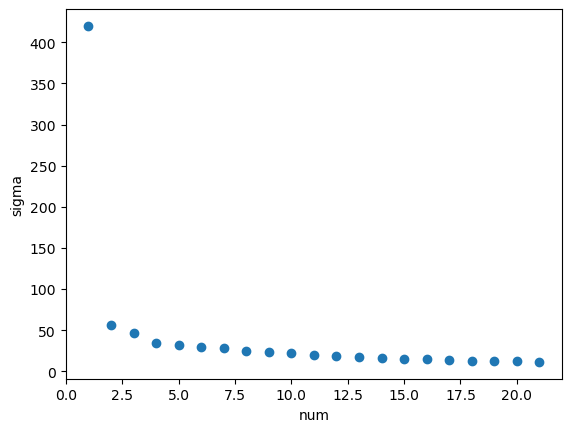

76.63114763601699


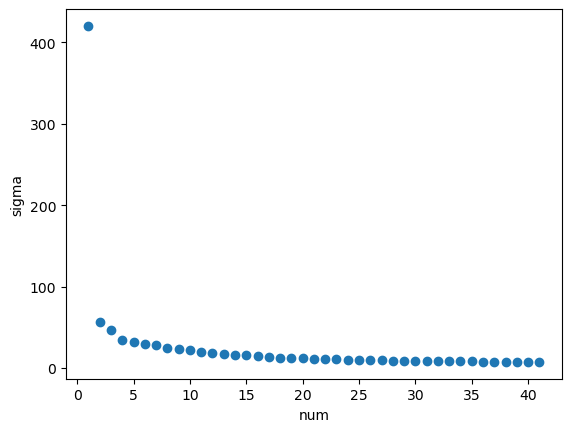

65.52352926033811


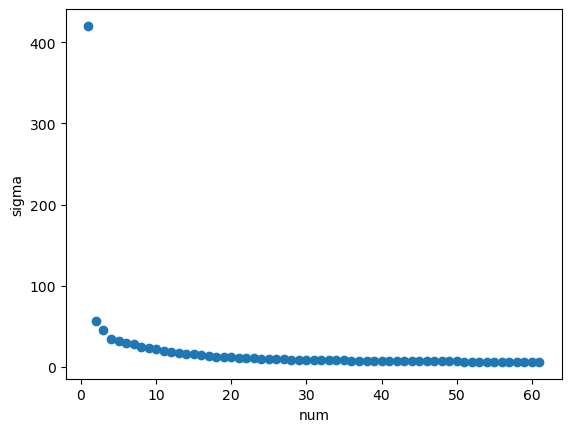

57.94875045687614


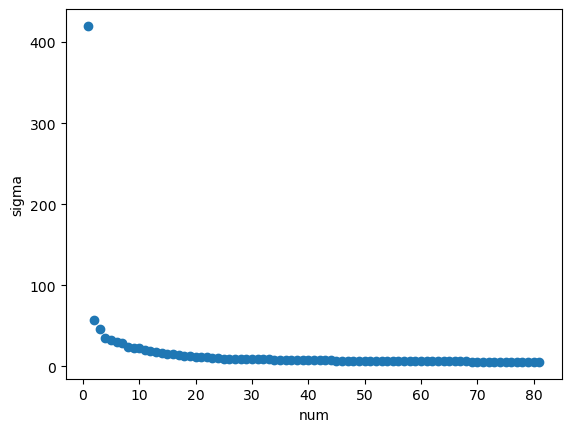

51.67490423939375


In [209]:
def plot_truncated_singular_values(T_SVD, i):
    plt.scatter(np.arange(1, T_SVD[1].shape[0] + 1, 1), np.diag(T_SVD[1]))
    plt.xlabel('num')
    plt.ylabel('sigma')
    plt.show()
    print(f'{np.linalg.norm(R - T_SVD[0] @ T_SVD[1] @ T_SVD[2])}')


for i in range(5):
    plot_truncated_singular_values(R_T_SVD[i], i)


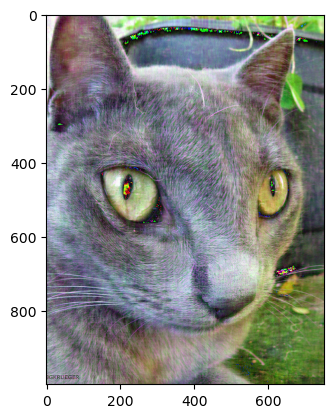

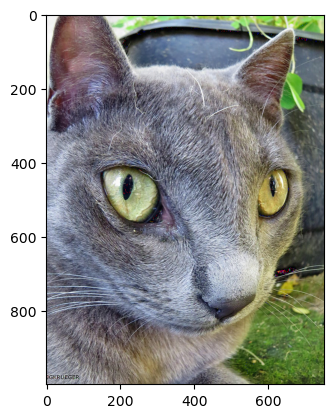

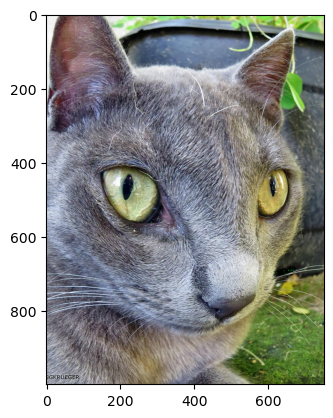

In [218]:

R_restored = read_from_shrinked(R_SVD[0][0], R_SVD[0][1], R_SVD[0][2])
G_restored = read_from_shrinked(G_SVD[0][0], G_SVD[0][1], G_SVD[0][2])
B_restored = read_from_shrinked(B_SVD[0][0], B_SVD[0][1], B_SVD[0][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()

R_restored = read_from_shrinked(R_SVD[1][0], R_SVD[1][1], R_SVD[1][2])
G_restored = read_from_shrinked(G_SVD[1][0], G_SVD[1][1], G_SVD[1][2])
B_restored = read_from_shrinked(B_SVD[1][0], B_SVD[1][1], B_SVD[1][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()

R_restored = read_from_shrinked(R_SVD[2][0], R_SVD[2][1], R_SVD[2][2])
G_restored = read_from_shrinked(G_SVD[2][0], G_SVD[2][1], G_SVD[2][2])
B_restored = read_from_shrinked(B_SVD[2][0], B_SVD[2][1], B_SVD[2][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()


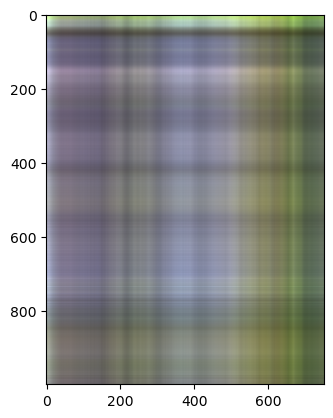

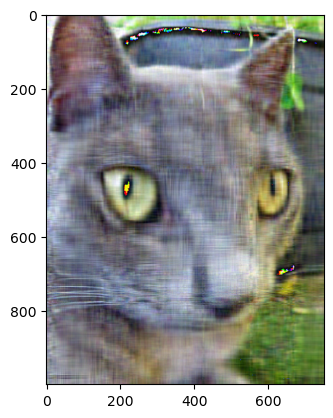

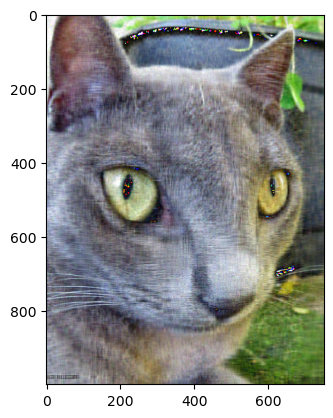

In [219]:
R_restored = read_from_shrinked(R_T_SVD[0][0], R_T_SVD[0][1], R_T_SVD[0][2])
G_restored = read_from_shrinked(G_T_SVD[0][0], G_T_SVD[0][1], G_T_SVD[0][2])
B_restored = read_from_shrinked(B_T_SVD[0][0], B_T_SVD[0][1], B_T_SVD[0][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()

R_restored = read_from_shrinked(R_T_SVD[1][0], R_T_SVD[1][1], R_T_SVD[1][2])
G_restored = read_from_shrinked(G_T_SVD[1][0], G_T_SVD[1][1], G_T_SVD[1][2])
B_restored = read_from_shrinked(B_T_SVD[1][0], B_T_SVD[1][1], B_T_SVD[1][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()

R_restored = read_from_shrinked(R_T_SVD[2][0], R_T_SVD[2][1], R_T_SVD[2][2])
G_restored = read_from_shrinked(G_T_SVD[2][0], G_T_SVD[2][1], G_T_SVD[2][2])
B_restored = read_from_shrinked(B_T_SVD[2][0], B_T_SVD[2][1], B_T_SVD[2][2])
restored_float = np.dstack((R_restored, G_restored, B_restored))
img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

plt.imshow(img_restored)
plt.show()
